# Predicting the duration of a trip of bicycle rental for UrbanBike

Aim:
- Predict the capacity in the next 30-90 min for showing it to customers on UrbanBike's application

Method:
- Predict the duration of the bike trips from the time when a bike is picked up from a docking station to the time when it is
returned to a docking station

Data we have from UrbanBike: 
- Bike docking stations
- Historical trips
- Weather data

Tasks:
- Perform data exploration
- Develop and evaluate a machine learning model to predict the duration of a trip
- Prepare a short presentation (15 mins max) outlining the modelling approach, results and any further steps you would propose to the client

## Data Exploration

In [106]:
import pandas as pd
# import geopandas as gpd
import matplotlib.pyplot as plt
from datetime import datetime
from geopy.distance import distance
import numpy as np

In [23]:
path = 'data/'

In [79]:
df_station = pd.read_csv(path + 'hubway_stations.csv')
df_trips = pd.read_csv(path + 'hubway_trips.csv')
df_weather = pd.read_csv(path + 'weather.csv')

### Exploring trip data

In [4]:
df_trips.sample(5,random_state=42)

,seq_id,hubway_id,status,duration,start_date,strt_statn,end_date,end_statn,bike_nr,subsc_type,zip_code,birth_date,gender
317347,317348,360655,Closed,905,7/4/2012 14:32:00,42.0,7/4/2012 14:47:00,39.0,B00480,Registered,'02118,1985.0,Female
1004796,1004797,1134287,Closed,120,7/14/2013 22:51:00,68.0,7/14/2013 22:53:00,75.0,B01462,Registered,'02115,NaN,Male
1416853,1416854,1576387,Closed,1020,10/11/2013 15:03:00,58.0,10/11/2013 15:20:00,52.0,B00205,Casual,'02215,NaN,NaN
335686,335687,380878,Closed,350,7/12/2012 07:50:00,26.0,7/12/2012 07:56:00,50.0,B00474,Registered,'02118,1975.0,Male
330414,330415,375163,Closed,425,7/10/2012 06:48:00,38.0,7/10/2012 06:55:00,64.0,B00023,Registered,'02478,1990.0,Male


In [5]:
df_trips['status'].unique()

array(['Closed'], dtype=object)

In [25]:
df_trips = df_trips.drop(columns=['status'])

In [29]:
df_trips.query('strt_statn==end_statn').shape[0], df_trips.shape[0]

(76311, 1579025)

76311 out of 1579025 trips having the same start and end stations.

<AxesSubplot:xlabel='strt_statn'>

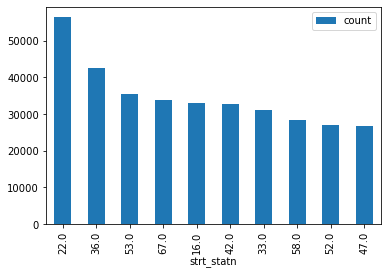

In [25]:
top10_strt_stdn = df_trips['strt_statn'].value_counts().reset_index().rename(columns={'index':'strt_statn','strt_statn':'count'})[:10]
top10_strt_stdn.set_index('strt_statn').plot.bar()

<AxesSubplot:xlabel='end_statn'>

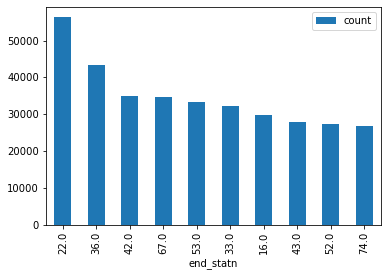

In [26]:
top10_end_stdn = df_trips['end_statn'].value_counts().reset_index().rename(columns={'index':'end_statn','end_statn':'count'})[:10]
top10_end_stdn.set_index('end_statn').plot.bar()

<AxesSubplot:>

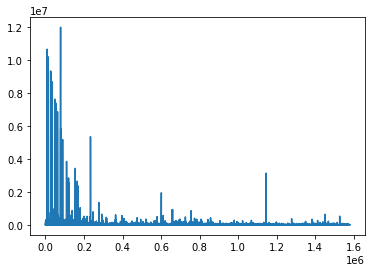

In [7]:
df_trips.duration.plot()

In [102]:
df_trips.value_counts('bike_nr')

bike_nr
B00490    2138
B00268    2124
B00548    2112
B00559    2091
B00563    2080
          ... 
T01129      49
B00218      35
B00137      31
B00542      28
T01064      10
Length: 1163, dtype: int64

In [26]:
def format_trip_date(string):
    return datetime.strptime(string,'%m/%d/%Y %H:%M:%S')
df_trips['start_date'] = df_trips['start_date'].apply(format_trip_date)
df_trips['end_date'] = df_trips['end_date'].apply(format_trip_date)

In [27]:
df_trips = df_trips.drop(columns=['seq_id','hubway_id'])

In [112]:
df_trips.describe()

,duration,strt_statn,end_statn,birth_date
count,1.579025e+06,1.579011e+06,1.578980e+06,350644.000000
mean,1.200280e+03,5.438039e+01,5.425603e+01,1976.295322
std,2.653539e+04,3.364295e+01,3.347219e+01,10.999742
min,-6.900000e+03,3.000000e+00,3.000000e+00,1932.000000
25%,4.120000e+02,2.700000e+01,2.900000e+01,1969.000000
50%,6.600000e+02,4.800000e+01,4.800000e+01,1979.000000
75%,1.082000e+03,7.400000e+01,7.400000e+01,1985.000000
max,1.199446e+07,1.450000e+02,1.450000e+02,1995.000000


In [111]:
df_trips.isna()

,duration,start_date,strt_statn,end_date,end_statn,bike_nr,subsc_type,zip_code,birth_date,gender,start_date_h,end_date_h
0,False,False,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...
1579020,False,False,False,False,False,False,False,False,True,False,False,False
1579021,False,False,False,False,False,False,False,False,True,False,False,False
1579022,False,False,False,False,False,False,False,True,True,True,False,False
1579023,False,False,False,False,False,False,False,False,True,False,False,False


In [110]:
df_trips.corr()

,duration,strt_statn,end_statn,birth_date
duration,1.000000,-0.004851,-0.005898,-0.002783
strt_statn,-0.004851,1.000000,0.340437,0.036458
end_statn,-0.005898,0.340437,1.000000,0.030073
birth_date,-0.002783,0.036458,0.030073,1.000000


### Exploring station data

In [20]:
df_station.sample(10, random_state=42)

,id,terminal,station,municipal,lat,lng,status
131,135,M32026,359 Broadway - Broadway at Fayette Street,Cambridge,42.370803,-71.104412,Existing
19,22,A32010,South Station - 700 Atlantic Ave.,Boston,42.352175,-71.055547,Existing
81,85,C32012,Andrew Station - Dorchester Ave at Humboldt Pl,Boston,42.330825,-71.057007,Removed
96,100,B32017,Dudley Square,Boston,42.328654,-71.084198,Existing
56,60,D32016,Charles Circle - Charles St. at Cambridge St.,Boston,42.360877,-71.071310,Removed
12,15,A32005,Harvard Real Estate - Brighton Mills - 370 Wes...,Boston,42.361667,-71.138020,Existing
98,102,C32002,Boston Medical Center - East Concord at Harri...,Boston,42.336437,-71.073089,Existing
65,69,K32001,Coolidge Corner - Beacon St @ Centre St,Brookline,42.341598,-71.123338,Existing
66,70,M32016,Harvard Kennedy School at Bennett St / Eliot St,Cambridge,42.372244,-71.121851,Existing
18,21,C32007,Prudential Center / Belvidere,Boston,42.345959,-71.082578,Existing


terminal (name), station (name) are not useful, so can be dropped

In [28]:
df_station = df_station.drop(columns=['terminal','station'])


In [30]:
df_station.shape

(142, 7)

In [38]:
df_station['municipal'].unique()

array(['Boston', 'Cambridge', 'Brookline', 'Somerville'], dtype=object)

In [24]:
df_station['color'] = df_station['status'].apply(lambda x: 'Black' if x == 'Existing' else 'Grey')

<AxesSubplot:xlabel='lng', ylabel='lat'>

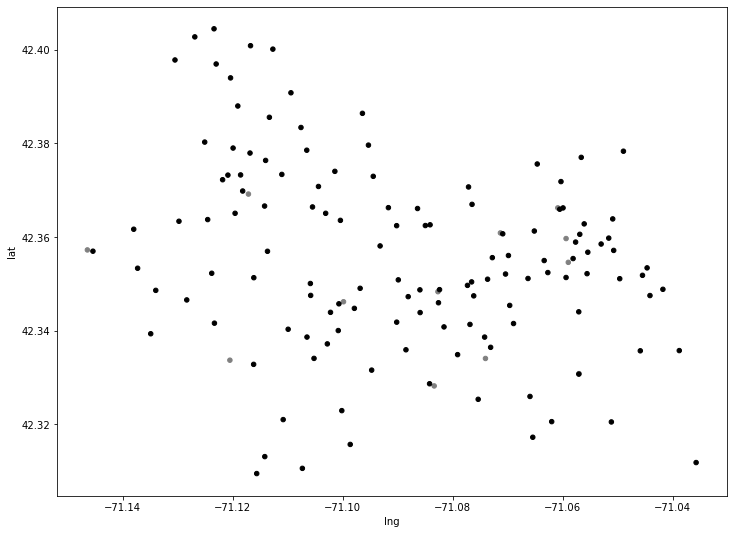

In [46]:
fig, ax = plt.subplots(figsize=(12,9))
df_station.plot(x="lng", y="lat", kind="scatter", c="color",ax=ax)

### Exploring weather data

In [10]:
df_weather.STATION.unique()

array(['COOP:190770'], dtype=object)

In [14]:
df_weather['Measurement_Flag'].unique()

array(['T', ' ', 'g'], dtype=object)

In [16]:
df_weather['Quality_Flag'].unique()

array([' '], dtype=object)

There is only one weather station, Quality_Flag Can be drop as it is null, so only DATE, HPCP(Hourly Precipitation) are useful.

In [80]:
df_weather = df_weather[['DATE', 'HPCP','Measurement_Flag']]

In [81]:
df_weather['DATE'] = df_weather['DATE'].apply(lambda x:datetime.strptime(x,'%Y%m%d %H:%M'))

<AxesSubplot:xlabel='DATE'>

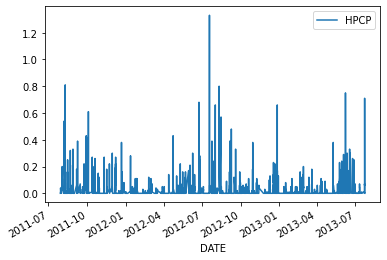

In [65]:
df_weather.plot(x='DATE',y='HPCP')

## Data Cleaning

### Merging dataframes

In [63]:
df_trips_s = df_trips.sample(100,random_state=42)

In [64]:
df = df_trips_s.merge(df_station, left_on= 'strt_statn',right_on='id',suffixes=('','_strt'))
df = df.merge(df_station, left_on= 'end_statn',right_on='id',suffixes=('','_end'))
df = df.rename(columns={'lat':'lat_strt','lng':'lng_strt'})
df = df.drop(columns=['id','id_end'])

In [65]:
df

,duration,start_date,strt_statn,end_date,end_statn,bike_nr,subsc_type,zip_code,birth_date,gender,municipal,lat_strt,lng_strt,status,municipal_end,lat_end,lng_end,status_end
0,905,2012-07-04 14:32:00,42.0,2012-07-04 14:47:00,39.0,B00480,Registered,'02118,1985.0,Female,Boston,42.352096,-71.070378,Existing,Boston,42.338623,-71.074182,Existing
1,377,2011-10-25 17:24:00,16.0,2011-10-25 17:30:00,39.0,B00519,Registered,'02118,1979.0,Male,Boston,42.347433,-71.076163,Existing,Boston,42.338623,-71.074182,Existing
2,366,2011-11-01 20:11:00,16.0,2011-11-01 20:17:00,39.0,B00580,Registered,'02118,1980.0,Male,Boston,42.347433,-71.076163,Existing,Boston,42.338623,-71.074182,Existing
3,1080,2013-11-13 18:19:00,42.0,2013-11-13 18:37:00,68.0,A07810,Registered,'02139,NaN,Male,Boston,42.352096,-71.070378,Existing,Cambridge,42.365070,-71.103100,Existing
4,1775,2011-09-11 15:52:00,42.0,2011-09-11 16:21:00,31.0,B00388,Casual,NaN,NaN,NaN,Boston,42.352096,-71.070378,Existing,Boston,42.348833,-71.041747,Existing
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,540,2013-07-15 19:35:00,94.0,2013-07-15 19:44:00,115.0,T01198,Registered,'02129,NaN,Female,Boston,42.375603,-71.064608,Existing,Boston,42.378338,-71.048927,Existing
96,909,2012-04-25 18:45:00,25.0,2012-04-25 19:00:00,9.0,b00225,Registered,'02118,1977.0,Male,Boston,42.341332,-71.076847,Existing,Boston,42.351313,-71.116174,Existing
97,300,2013-05-09 15:59:00,70.0,2013-05-09 16:04:00,18.0,B00101,Registered,'02134,NaN,Male,Cambridge,42.372244,-71.121851,Existing,Boston,42.363370,-71.129791,Existing
98,900,2013-10-13 14:10:00,6.0,2013-10-13 14:25:00,49.0,B00433,Registered,'01720,NaN,Male,Boston,42.361285,-71.065140,Existing,Boston,42.351146,-71.066289,Existing


In [66]:
def hour_rounder(t):
    return t.replace(second=0, microsecond=0, minute=0, hour=t.hour)
df['start_date_h'] = df['start_date'].apply(hour_rounder)
df['end_date_h'] = df['end_date'].apply(hour_rounder)

In [70]:
df['start_date_h']

0    2012-07-04 14:00:00
1    2011-10-25 17:00:00
2    2011-11-01 20:00:00
3    2013-11-13 18:00:00
4    2011-09-11 15:00:00
             ...        
95   2013-07-15 19:00:00
96   2012-04-25 18:00:00
97   2013-05-09 15:00:00
98   2013-10-13 14:00:00
99   2011-08-12 08:00:00
Name: start_date_h, Length: 100, dtype: datetime64[ns]

In [ ]:
df_weather_rain = df_weather.query('HPCP != 0 or Measurement_Flag=="T"')
df_weather_rain['rain'] = 1

In [93]:
# df_ = df.merge(df_weather_rain, left_on= 'start_date_h',right_on='DATE',suffixes=('','_start_date'))
df_ = df_.merge(df_weather, left_on= 'end_date_h',right_on='DATE',suffixes=('','_end_date'))
# df_ = df_.drop(columns=['DATE','DATE_end_date'])
df_

,duration,start_date,strt_statn,end_date,end_statn,bike_nr,subsc_type,zip_code,birth_date,gender,...,status_end,start_date_h,end_date_h,DATE,HPCP,Measurement_Flag,rain,DATE_end_date,HPCP_end_date,Measurement_Flag_end_date
0,180,2013-06-17 19:03:00,26.0,2013-06-17 19:06:00,102.0,T01275,Registered,'02127,NaN,Male,...,Existing,2013-06-17 19:00:00,2013-06-17 19:00:00,2013-06-17 19:00:00,0.06,,1,2013-06-17 19:00:00,0.06,
1,218,2011-09-06 17:40:00,22.0,2011-09-06 17:43:00,43.0,B00035,Registered,'02043,1950.0,Male,...,Existing,2011-09-06 17:00:00,2011-09-06 17:00:00,2011-09-06 17:00:00,0.00,T,1,2011-09-06 17:00:00,0.00,T
2,10532,2012-09-04 09:04:00,21.0,2012-09-04 12:00:00,21.0,T01399,Casual,NaN,NaN,NaN,...,Existing,2012-09-04 09:00:00,2012-09-04 12:00:00,2012-09-04 09:00:00,0.00,T,1,2012-09-04 12:00:00,0.02,
3,960,2013-06-13 17:40:00,80.0,2013-06-13 17:56:00,98.0,B00605,Registered,'02129,NaN,Male,...,Existing,2013-06-13 17:00:00,2013-06-13 17:00:00,2013-06-13 17:00:00,0.00,T,1,2013-06-13 17:00:00,0.00,T
4,300,2013-05-09 15:59:00,70.0,2013-05-09 16:04:00,18.0,B00101,Registered,'02134,NaN,Male,...,Existing,2013-05-09 15:00:00,2013-05-09 16:00:00,2013-05-09 15:00:00,0.00,T,1,2013-05-09 16:00:00,0.01,


In [105]:
df['start_date_time'] = df['start_date'].apply(lambda x: x.time())
df['start_date_date'] = df['start_date'].apply(lambda x: x.date())
df['start_date_date']

0     2012-07-04
1     2011-10-25
2     2011-11-01
3     2013-11-13
4     2011-09-11
         ...    
95    2013-07-15
96    2012-04-25
97    2013-05-09
98    2013-10-13
99    2011-08-12
Name: start_date_date, Length: 100, dtype: object

In [94]:
def get_distance(x):
    return distance((x['lat_strt'],x['lng_strt']),(x['lat_end'],x['lng_end'])).km
df['statn_dist'] = df[['lat_strt','lng_strt','lat_end','lng_end']].apply(get_distance, axis=1)

In [95]:
df['statn_dist']

0     1.529054
1     0.992136
2     0.992136
3     3.056812
4     2.386722
        ...   
95    1.326739
96    3.424956
97    1.182970
98    1.130213
99    0.819267
Name: statn_dist, Length: 100, dtype: float64

In [96]:
df

,duration,start_date,strt_statn,end_date,end_statn,bike_nr,subsc_type,zip_code,birth_date,gender,...,lat_strt,lng_strt,status,municipal_end,lat_end,lng_end,status_end,start_date_h,end_date_h,statn_dist
0,905,2012-07-04 14:32:00,42.0,2012-07-04 14:47:00,39.0,B00480,Registered,'02118,1985.0,Female,...,42.352096,-71.070378,Existing,Boston,42.338623,-71.074182,Existing,2012-07-04 14:00:00,2012-07-04 14:00:00,1.529054
1,377,2011-10-25 17:24:00,16.0,2011-10-25 17:30:00,39.0,B00519,Registered,'02118,1979.0,Male,...,42.347433,-71.076163,Existing,Boston,42.338623,-71.074182,Existing,2011-10-25 17:00:00,2011-10-25 17:00:00,0.992136
2,366,2011-11-01 20:11:00,16.0,2011-11-01 20:17:00,39.0,B00580,Registered,'02118,1980.0,Male,...,42.347433,-71.076163,Existing,Boston,42.338623,-71.074182,Existing,2011-11-01 20:00:00,2011-11-01 20:00:00,0.992136
3,1080,2013-11-13 18:19:00,42.0,2013-11-13 18:37:00,68.0,A07810,Registered,'02139,NaN,Male,...,42.352096,-71.070378,Existing,Cambridge,42.365070,-71.103100,Existing,2013-11-13 18:00:00,2013-11-13 18:00:00,3.056812
4,1775,2011-09-11 15:52:00,42.0,2011-09-11 16:21:00,31.0,B00388,Casual,NaN,NaN,NaN,...,42.352096,-71.070378,Existing,Boston,42.348833,-71.041747,Existing,2011-09-11 15:00:00,2011-09-11 16:00:00,2.386722
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,540,2013-07-15 19:35:00,94.0,2013-07-15 19:44:00,115.0,T01198,Registered,'02129,NaN,Female,...,42.375603,-71.064608,Existing,Boston,42.378338,-71.048927,Existing,2013-07-15 19:00:00,2013-07-15 19:00:00,1.326739
96,909,2012-04-25 18:45:00,25.0,2012-04-25 19:00:00,9.0,b00225,Registered,'02118,1977.0,Male,...,42.341332,-71.076847,Existing,Boston,42.351313,-71.116174,Existing,2012-04-25 18:00:00,2012-04-25 19:00:00,3.424956
97,300,2013-05-09 15:59:00,70.0,2013-05-09 16:04:00,18.0,B00101,Registered,'02134,NaN,Male,...,42.372244,-71.121851,Existing,Boston,42.363370,-71.129791,Existing,2013-05-09 15:00:00,2013-05-09 16:00:00,1.182970
98,900,2013-10-13 14:10:00,6.0,2013-10-13 14:25:00,49.0,B00433,Registered,'01720,NaN,Male,...,42.361285,-71.065140,Existing,Boston,42.351146,-71.066289,Existing,2013-10-13 14:00:00,2013-10-13 14:00:00,1.130213


## Modelling

In [111]:
from sklearn.linear_model import LinearRegression
X = df[['statn_dist','strt_statn','end_statn']]
y = df['duration']
reg = LinearRegression().fit(X, y)
reg.score(X, y)

0.043899829623797126